# Metis practice take home assignment - Citibike Data

### Question 1

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import wget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
url_base = 'https://s3.amazonaws.com/tripdata/'
response = urllib.request.urlopen(url_base)

In [4]:
html = response.read()

In [5]:
soup = BeautifulSoup(html, 'html.parser')

In [13]:
keys_2015 = [key.text for key in soup.find_all('key') if '2015' in key.text]
keys_2015

['201501-citibike-tripdata.zip',
 '201502-citibike-tripdata.zip',
 '201503-citibike-tripdata.zip',
 '201504-citibike-tripdata.zip',
 '201505-citibike-tripdata.zip',
 '201506-citibike-tripdata.zip',
 '201507-citibike-tripdata.zip',
 '201508-citibike-tripdata.zip',
 '201509-citibike-tripdata.zip',
 '201510-citibike-tripdata.zip',
 '201511-citibike-tripdata.zip',
 '201512-citibike-tripdata.zip']

In [14]:
# Downloads the data to home directory on computer

for url_end in keys_2015:
    wget.download(url_base + url_end)

100% [....................................................] 23145783 / 23145783

In [4]:
# Combines all the monthly data into one DataFrame

df = pd.DataFrame()
n = 12
for i in range(1, n+1):
    df_temp = pd.read_csv('2015{}-citibike-tripdata.zip'.format(i if i >= 10 else '0' + str(i)))
    df = pd.concat([df, df_temp], ignore_index=True)    

In [57]:
df.shape

(9937969, 15)

There are 9937969 data points for the year 2015.

### Question 2

In [4]:
df.head()


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


In [5]:
# Filter out trip duration outliers (arbitrarily chosen to be greater or less than 10 times mean)

df = df[np.abs(df['tripduration']-df['tripduration'].mean())<=(10*df['tripduration'].std())]
df.shape

(9934709, 15)

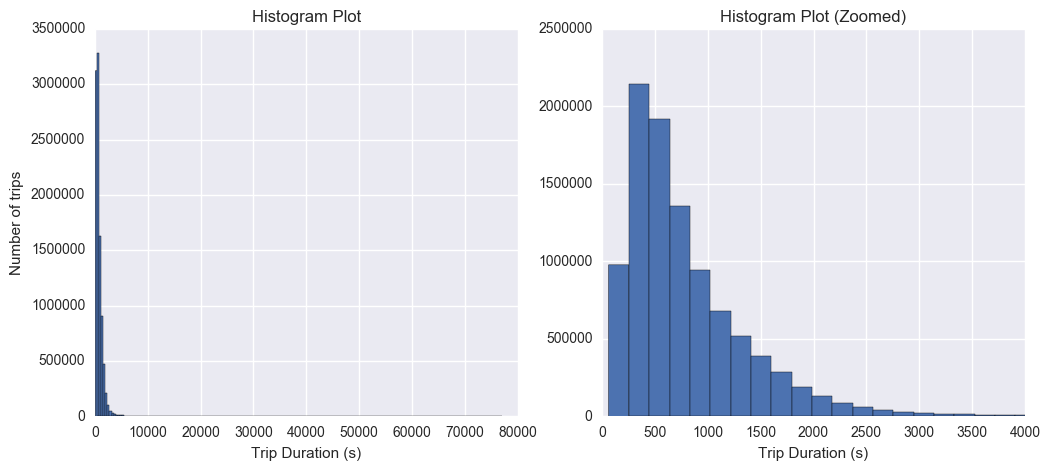

In [55]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Histogram Plot')
plt.ylabel('Number of trips')
plt.xlabel('Trip Duration (s)')
plt.hist(df.tripduration, bins=200);
plt.subplot(122)
plt.title('Histogram Plot (Zoomed)')
plt.xlim(0,4000)
plt.xlabel('Trip Duration (s)')
plt.hist(df.tripduration, bins=400);

There are instances where the trip duraion is 0 minutes, which could just mean the rider changed their mind and decided not to ride the bike, or if the bike was not suitable for riding (flat tire, etc.). 

The most common trip duration is around 5 minutes, which should enable the rider to travel around 1 mile in the city. This shows that most riders use the service for short-term riding, and might prefer a car service to travel longer distances.

There are also some outliers with trip durations longer than a whole day. 
This could be caused by the rider deciding to keep the bike overnight, forgetting to return it, or if the bike got lost or stolen.

### Question 3

In [42]:
# Had to downsize dataset by factor of 10 due to computing power restraints

df1 = df.sample(1000000)

In [45]:
# Convert start and stop times to datetime format

def lookup(s):
    dates = {date:pd.to_datetime(date, errors='coerce', format='%m/%d/%Y %H:%M', exact=False) for date in s.unique()}
    return s.map(dates)

df1.loc[:,'starttime'] = lookup(df1.loc[:,'starttime'])
df1.loc[:,'stoptime'] = lookup(df1.loc[:,'stoptime'])

In [91]:
df1['Month'] = df1.starttime.apply(lambda x: x.month)
df1['Weekday'] = df1.starttime.apply(lambda x: x.weekday())
df1['Hour'] = df1.starttime.apply(lambda x: x.hour)
df1['Is Weekend'] = df1.Weekday.apply(lambda x: 1 if x == 5 or x == 6 else 0)

In [92]:
df1.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Month,Weekday,Hour,Is Weekend
1176181,273,2015-04-18 13:00:00,2015-04-18 13:04:00,377,6 Ave & Canal St,40.722438,-74.005664,146,Hudson St & Reade St,40.716250,-74.009106,16213,Subscriber,1956.0,1,4,5,13,1
3643455,954,2015-07-09 10:53:00,2015-07-09 11:09:00,326,E 11 St & 1 Ave,40.729538,-73.984267,490,8 Ave & W 33 St,40.751551,-73.993934,21234,Subscriber,1973.0,1,7,3,10,0
4263514,526,2015-07-26 15:48:00,2015-07-26 15:57:00,445,E 10 St & Avenue A,40.727408,-73.981420,345,W 13 St & 6 Ave,40.736494,-73.997044,22185,Subscriber,1989.0,1,7,6,15,1
781092,484,2015-03-28 17:34:00,2015-03-28 17:42:00,329,Greenwich St & N Moore St,40.720434,-74.010206,127,Barrow St & Hudson St,40.731724,-74.006744,19735,Subscriber,1978.0,1,3,5,17,1
9089843,609,2015-11-29 12:02:00,2015-11-29 12:12:00,251,Mott St & Prince St,40.723180,-73.994800,358,Christopher St & Greenwich St,40.732916,-74.007114,20889,Subscriber,1972.0,1,11,6,12,1


In [102]:
df_hour = df1.groupby('Hour').count().reset_index()
df_hour.head()

,Hour,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Month,Weekday,Is Weekend
0,0,9582,9582,9582,9582,9582,9582,9582,9582,9582,9582,9582,9582,9582,8226,9582,9582,9582,9582
1,1,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,4587,5427,5427,5427,5427
2,2,3158,3158,3158,3158,3158,3158,3158,3158,3158,3158,3158,3158,3158,2653,3158,3158,3158,3158
3,3,1973,1973,1973,1973,1973,1973,1973,1973,1973,1973,1973,1973,1973,1655,1973,1973,1973,1973
4,4,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853,1633,1853,1853,1853,1853


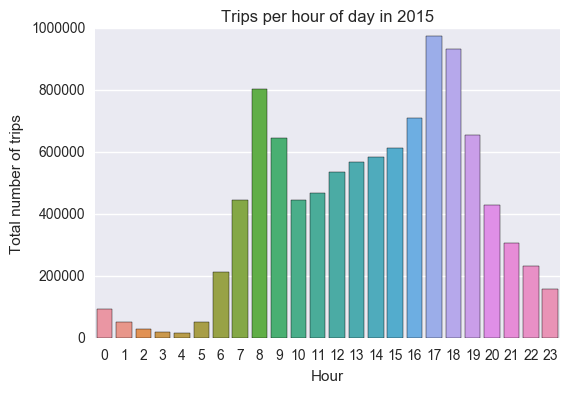

In [308]:
sns.barplot(df_hour.Hour, df_hour.tripduration*10) # Multiplying by 10 since I downsized the dataset size by 10x
plt.ylabel('Total number of trips')
plt.title('Trips per hour of day in 2015');

In [150]:
df_weekend = df1.groupby(["Is Weekend", "Hour"]).count().reset_index()
df_weekend.head()

,Is Weekend,Hour,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Month,Weekday
0,0,0,5879,5879,5879,5879,5879,5879,5879,5879,5879,5879,5879,5879,5879,5111,5879,5879,5879
1,0,1,2811,2811,2811,2811,2811,2811,2811,2811,2811,2811,2811,2811,2811,2378,2811,2811,2811
2,0,2,1520,1520,1520,1520,1520,1520,1520,1520,1520,1520,1520,1520,1520,1293,1520,1520,1520
3,0,3,920,920,920,920,920,920,920,920,920,920,920,920,920,790,920,920,920
4,0,4,1134,1134,1134,1134,1134,1134,1134,1134,1134,1134,1134,1134,1134,1043,1134,1134,1134


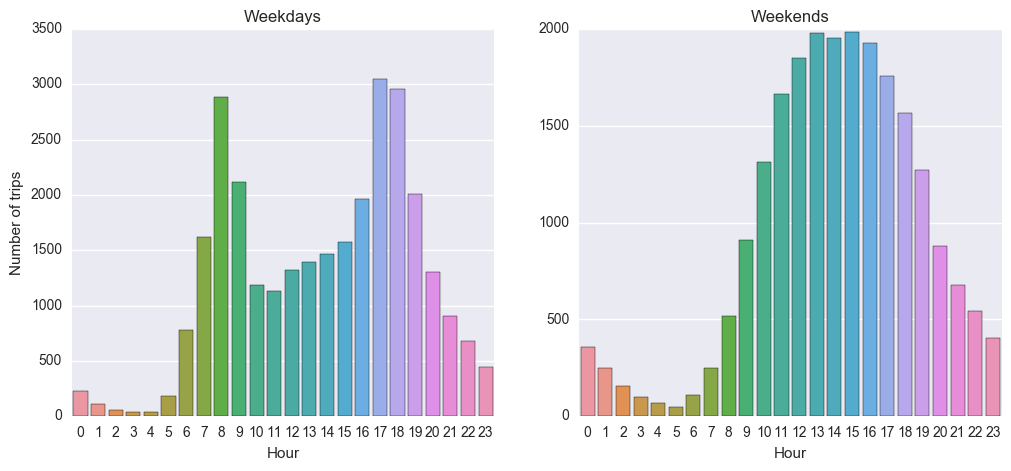

In [313]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.barplot(df_weekend.Hour.iloc[:24], df_weekend.tripduration.iloc[:24]/5*10/52)
plt.ylabel('Number of trips')
plt.title('Weekdays')

plt.subplot(122)
sns.barplot(df_weekend.Hour.iloc[24:], df_weekend.tripduration.iloc[24:]/2*10/52)
plt.ylabel('')
plt.title('Weekends');

There a bimodal distribution on weekdays, with peaks centered around 8 AM and 6 PM, which implies that a large proporition of riders use the service for their commute to and from work. 
On weekends the number of riders is greatest in the afternoon, which indicates that people are riding for leisure. 
Overall the number of riders per day is about the same regardless of weekday or weekend. 

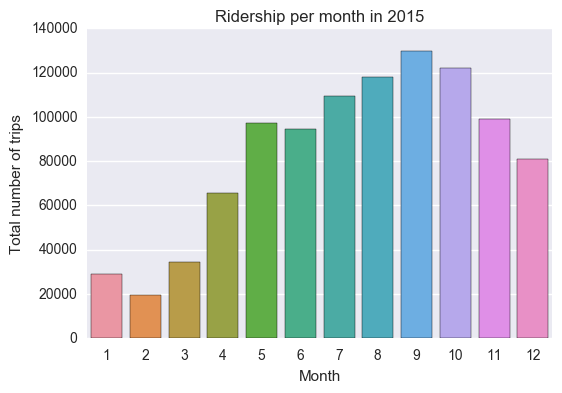

In [168]:
# Segmenting the data by month

df_month = df1.groupby('Month').count().reset_index()
sns.barplot(df_month.Month, df_month.tripduration)
plt.ylabel('Total number of trips')
plt.title('Ridership per month in 2015');

Ridership is much lower in the winter months when it is more likely to be cold, raining, or snowing. Note that this does not account for the popularity growth of CitiBike over time, which could explain for some of the upwards trend.

In [68]:
df = df.sort_values(['bikeid','starttime'])

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
1524,332,1/1/2015 12:28,1/1/2015 12:34,326,E 11 St & 1 Ave,40.729538,-73.984267,497,E 17 St & Broadway,40.737050,-73.990093,14529,Subscriber,1982.0,1
1793,829,1/1/2015 13:11,1/1/2015 13:24,497,E 17 St & Broadway,40.737050,-73.990093,515,W 43 St & 10 Ave,40.760094,-73.994618,14529,Subscriber,1991.0,1
94762,387,1/12/2015 10:22,1/12/2015 10:29,479,9 Ave & W 45 St,40.760193,-73.991255,512,W 29 St & 9 Ave,40.750073,-73.998393,14529,Subscriber,1985.0,1
95286,160,1/12/2015 14:08,1/12/2015 14:11,512,W 29 St & 9 Ave,40.750073,-73.998393,489,10 Ave & W 28 St,40.750664,-74.001768,14529,Subscriber,1971.0,1
95408,392,1/12/2015 15:01,1/12/2015 15:08,489,10 Ave & W 28 St,40.750664,-74.001768,515,W 43 St & 10 Ave,40.760094,-73.994618,14529,Subscriber,1969.0,1
95589,591,1/12/2015 15:55,1/12/2015 16:05,515,W 43 St & 10 Ave,40.760094,-73.994618,434,9 Ave & W 18 St,40.743174,-74.003664,14529,Subscriber,1979.0,1
95984,419,1/12/2015 16:50,1/12/2015 16:57,434,9 Ave & W 18 St,40.743174,-74.003664,357,E 11 St & Broadway,40.732618,-73.991580,14529,Subscriber,1984.0,1
97689,1060,1/12/2015 18:20,1/12/2015 18:37,357,E 11 St & Broadway,40.732618,-73.991580,469,Broadway & W 53 St,40.763441,-73.982681,14529,Subscriber,1984.0,1
98389,703,1/12/2015 18:52,1/12/2015 19:03,469,Broadway & W 53 St,40.763441,-73.982681,490,8 Ave & W 33 St,40.751551,-73.993934,14529,Subscriber,1959.0,1
98808,801,1/12/2015 19:16,1/12/2015 19:29,490,8 Ave & W 33 St,40.751551,-73.993934,352,W 56 St & 6 Ave,40.763406,-73.977225,14529,Subscriber,1983.0,1


### Question 4

If a bike's next trip originates from a different station than its previously returned address, it could be possible that the GPS tracker temporarily malfunctioned and did not record some data, or the bikes are being moved by the company to allocate more bikes to busier areas. 

In [188]:
# Goal is to filter the data to show only data points where the next trip of a bike originated from a different 
# location than its previouslsy returned address

# Sort by each bikeid then starttime

# Only looking at May data to due to memory constraints and the fact that a random sample is not continuous
df_may = pd.read_csv('201505-citibike-tripdata.zip') 
df_sorted = df_may.sort_values(['bikeid', 'starttime'])

In [194]:
df_sorted['Shifted start'] = df_sorted['start station name'].shift(-1)
df_sorted['Shifted bikeid'] = df_sorted['bikeid'].shift(-1)

In [203]:
# Shows only the data points where the start location is is different than the previous end location, for the same bike 

df_sorted[(df_sorted['Shifted start'] != df_sorted['end station name']) & (df_sorted['bikeid'] == df_sorted['Shifted bikeid'])]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Shifted start,Shifted bikeid
388414,1385,5/13/2015 17:55:39,5/13/2015 18:18:45,147,Greenwich St & Warren St,40.715422,-74.011220,433,E 13 St & Avenue A,40.729554,-73.980572,14529,Subscriber,1989.0,1,Pershing Square South,14529.0
604745,1574,5/20/2015 11:02:09,5/20/2015 11:28:23,444,Broadway & W 24 St,40.742354,-73.989151,279,Peck Slip & Front St,40.707873,-74.001670,14529,Customer,NaN,0,South St & Whitehall St,14529.0
646332,1832,5/21/2015 16:39:53,5/21/2015 17:10:26,312,Allen St & E Houston St,40.722055,-73.989111,455,1 Ave & E 44 St,40.750020,-73.969053,14529,Customer,NaN,0,E 59 St & Sutton Pl,14529.0
790852,881,5/26/2015 17:29:13,5/26/2015 17:43:54,375,Mercer St & Bleecker St,40.726795,-73.996951,147,Greenwich St & Warren St,40.715422,-74.011220,14529,Subscriber,1985.0,2,8 Ave & W 31 St,14529.0
205377,861,5/7/2015 19:00:27,5/7/2015 19:14:48,238,Bank St & Washington St,40.736197,-74.008592,250,Lafayette St & Jersey St,40.724561,-73.995653,14529,Subscriber,1987.0,2,W 13 St & 6 Ave,14529.0
11015,3499,5/1/2015 12:49:42,5/1/2015 13:48:01,477,W 41 St & 8 Ave,40.756405,-73.990026,523,W 38 St & 8 Ave,40.754666,-73.991382,14531,Subscriber,1989.0,1,E 10 St & Avenue A,14531.0
274539,2294,5/10/2015 10:49:34,5/10/2015 11:27:49,147,Greenwich St & Warren St,40.715422,-74.011220,468,Broadway & W 55 St,40.765265,-73.981923,14531,Customer,NaN,0,8 Ave & W 52 St,14531.0
285426,790,5/10/2015 16:10:17,5/10/2015 16:23:28,2006,Central Park S & 6 Ave,40.765909,-73.976342,290,2 Ave & E 58 St,40.760203,-73.964785,14531,Subscriber,1985.0,1,E 10 St & Avenue A,14531.0
312680,501,5/11/2015 15:24:32,5/11/2015 15:32:53,359,E 47 St & Park Ave,40.755103,-73.974987,477,W 41 St & 8 Ave,40.756405,-73.990026,14531,Subscriber,1976.0,1,E 30 St & Park Ave S,14531.0
397461,923,5/13/2015 23:10:33,5/13/2015 23:25:57,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,311,Norfolk St & Broome St,40.717227,-73.988021,14531,Subscriber,1985.0,1,Pershing Square South,14531.0


This occured out 70273 times of a total of 956510 trips for the month of May 2015, so roughly 7% of the time.

### Question 5

In [131]:
# Import weather data scraped from https://daily-weather.weatherdb.com/d/a/New-York-City%2C-NY
# This requires some manual work

weather = pd.read_csv('Weather.csv', names=['date', 'temp avg', 'temp max', 'temp min', 'precipitation', 'snow'])

In [260]:
# Convert data to float 

weather.precipitation = weather.precipitation.apply(lambda x: float(x.split('\n')[0]))
weather['temp avg'] = weather['temp avg'].apply(lambda x: float(x.split('\n')[0]))
weather.snow = weather.snow.apply(lambda x: float(x.split('\n')[0]))
weather.drop(weather[['date', 'temp max', 'temp min']], axis=1, inplace=True)
weather.head()

,temp avg,precipitation,snow
0,32.3,0.00,0.0
1,38.7,0.00,0.0
2,36.3,0.46,0.0
3,46.7,0.72,0.1
4,40.0,0.07,0.0


In [256]:
# Group total counts per day

df1['Day'] = df1.starttime.apply(lambda x: x.dayofyear)
df_day = df1.groupby('Day').count().reset_index()
df_day.drop(df_day.columns[2:], axis=1, inplace=True)
df_day.rename(columns={'tripduration':'Total Number of Trips'}, inplace=True)
df_day.head()

,Day,Total Number of Trips
0,1,511
1,2,1126
2,3,440
3,4,785
4,5,1470


In [263]:
# Concatenate weather data to trip data

df_day = pd.concat([df_day, weather], axis=1)
df_day.head()

,Day,Total Number of Trips,temp avg,precipitation,snow
0,1,511,32.3,0.00,0.0
1,2,1126,38.7,0.00,0.0
2,3,440,36.3,0.46,0.0
3,4,785,46.7,0.72,0.1
4,5,1470,40.0,0.07,0.0


In [301]:
# Set-up environment for xgboost

mingw_path = r'C:\Program Files\mingw-w64\x86_64-6.2.0-posix-seh-rt_v5-rev1'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression

In [303]:
# Train-test split

X = df_day.ix[:, 2:]
y = df_day.loc[:, 'Total Number of Trips']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.8, random_state=0)

In [304]:
# Simple linear regression model

lr = LinearRegression().fit(X_train, y_train)
predictions = lr.predict(X_test)
print(lr.score(X_test, y_test))

0.674334643065


In [305]:
# XGBoost model

gbm = xgb.XGBRegressor(max_depth=3, n_estimators=100, learning_rate=0.05).fit(X_train, y_train)
predictions = gbm.predict(X_test)
print(gbm.score(X_test, y_test))

0.690562835855


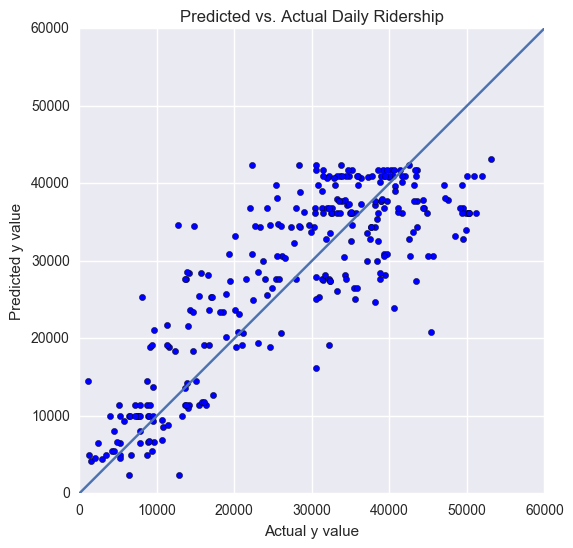

In [306]:
plt.figure(figsize=(6,6))
plt.title('Predicted vs. Actual Daily Ridership')
plt.xlabel('Actual y value')
plt.ylabel('Predicted y value')
plt.ylim(0,60000)
plt.xlim(0,60000)
plt.scatter(y_test*10, predictions*10) # Multiplying by 10 since I downsized the dataset size by 10x
plt.plot(range(60000), range(60000));

Overall, it's inherently difficult to predict the total number of daily CitiBike trips since we only have 365 data points per year.
Using weather data can explain some of the variance. It is obvious that people will be less likely to ride bikes when it is cold, raining, or snowing outside. This was the same conclusion from the plot of ridership vs. month.
One downside to the weather model is that the weather features are likely to be correlated. For example, it is unlikely to rain and snow at the same time, and it is more likely to snow when the temperature is low. 

### Question 6

In [250]:
# My idea is to extract the latitude and longitude data then plot it using an online mapping tool like BatchGeo
# This just shows how to extract some of the lat-long data in a copyable format

df2 = df1.head(100)
df2['LatLong'] = df2['start station latitude'].map(str) + ', ' + df2['start station longitude'].map(str)
df2.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,gender,Month,Weekday,Hour,Is Weekend,Day,LatLong
1176181,273,2015-04-18 13:00:00,2015-04-18 13:04:00,377,6 Ave & Canal St,40.722438,-74.005664,146,Hudson St & Reade St,40.716250,...,16213,Subscriber,1956.0,1,4,5,13,1,108,"40.72243797, -74.00566443"
3643455,954,2015-07-09 10:53:00,2015-07-09 11:09:00,326,E 11 St & 1 Ave,40.729538,-73.984267,490,8 Ave & W 33 St,40.751551,...,21234,Subscriber,1973.0,1,7,3,10,0,190,"40.72953837, -73.98426726"
4263514,526,2015-07-26 15:48:00,2015-07-26 15:57:00,445,E 10 St & Avenue A,40.727408,-73.981420,345,W 13 St & 6 Ave,40.736494,...,22185,Subscriber,1989.0,1,7,6,15,1,207,"40.72740794, -73.98142006"
781092,484,2015-03-28 17:34:00,2015-03-28 17:42:00,329,Greenwich St & N Moore St,40.720434,-74.010206,127,Barrow St & Hudson St,40.731724,...,19735,Subscriber,1978.0,1,3,5,17,1,87,"40.72043411, -74.01020609"
9089843,609,2015-11-29 12:02:00,2015-11-29 12:12:00,251,Mott St & Prince St,40.723180,-73.994800,358,Christopher St & Greenwich St,40.732916,...,20889,Subscriber,1972.0,1,11,6,12,1,333,"40.72317958, -73.99480012"


In [242]:
print(df2['LatLong'].to_string(index=False))

40.72243797, -74.00566443
             40.72953837, -73.98426726
             40.72740794, -73.98142006
             40.72043411, -74.01020609
             40.72317958, -73.99480012
             40.72953837, -73.98426726
             40.72740794, -73.98142006
              40.76019252, -73.9912551
        40.746646999999996, -73.993915
             40.72057658, -73.96150225
             40.75500254, -73.98014437
             40.72362738, -73.99949601
             40.73524276, -73.98758561
             40.72043411, -74.01020609
             40.71893904, -73.99266288
                 40.722055, -73.989111
             40.72502876, -73.99069656
             40.75172632, -73.98753523
                 40.689888, -73.981013
             40.75255434, -73.97282625
             40.71745169, -73.95850939
                 40.724399, -74.004704
              40.73028666, -73.9907647
             40.72405549, -74.00965965
             40.75066386, -74.00176802
40.751872999999996, -73.97770600000001